Visualization saved as NUMT_comprehensive_analysis.png and .pdf


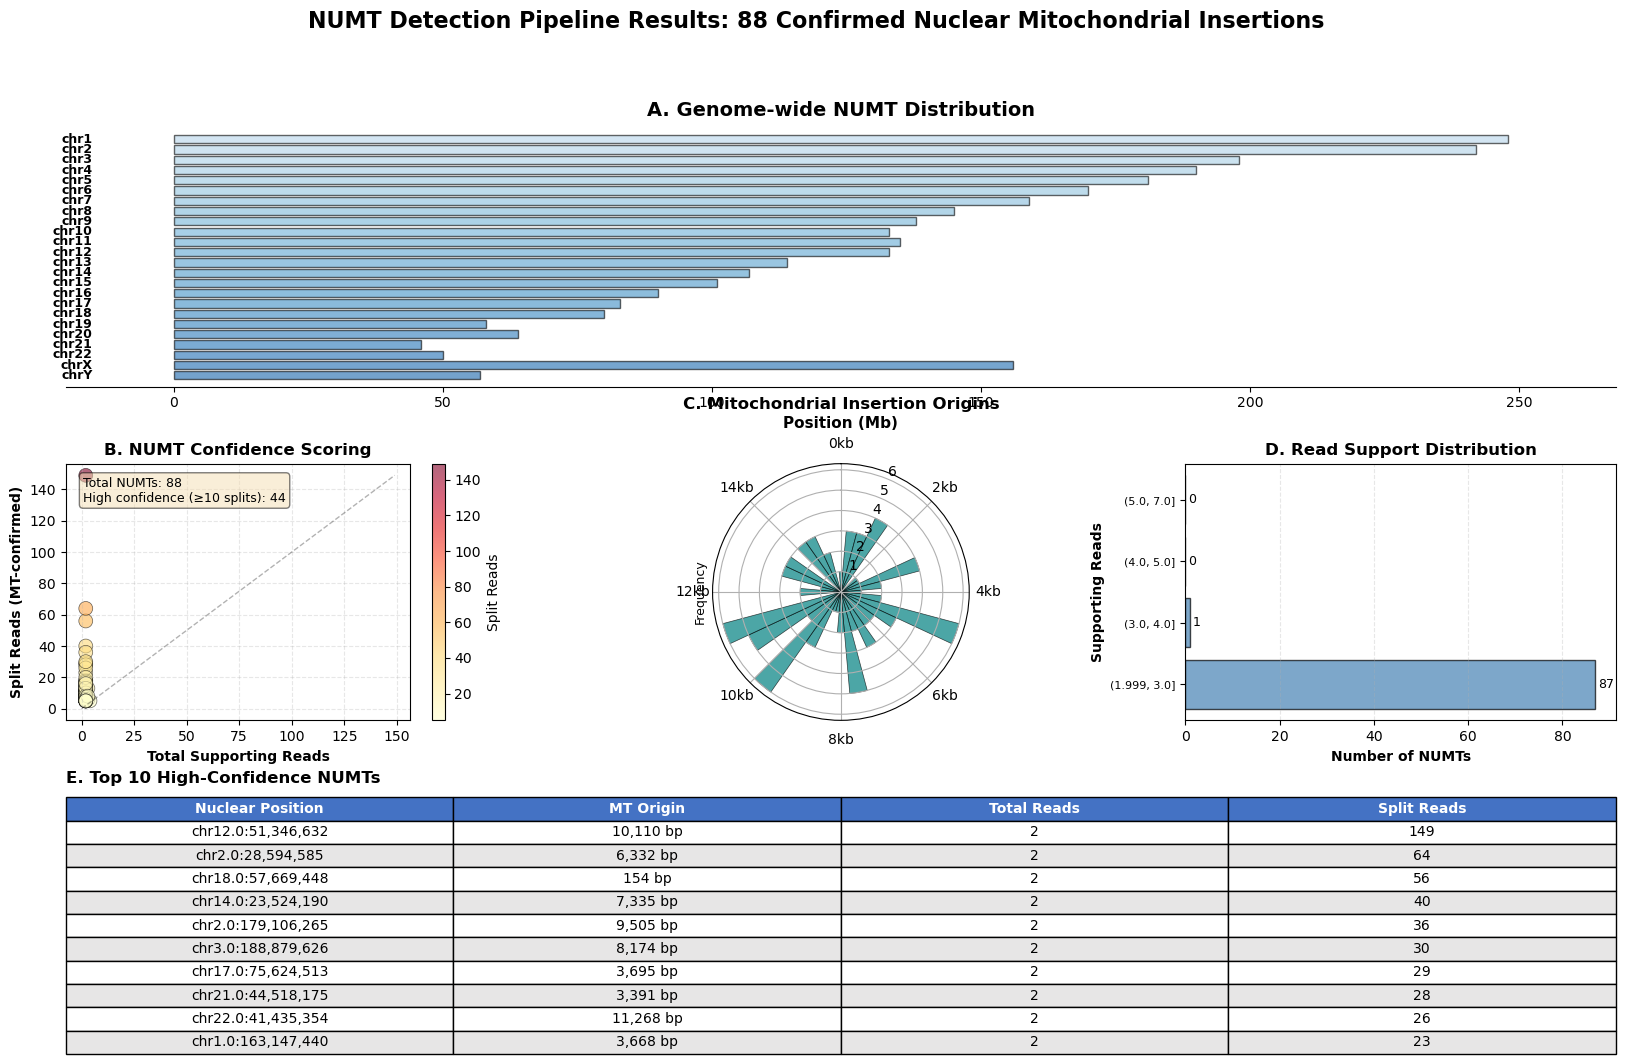

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Load your confirmed NUMT clusters
CSV_PATH = "../results/confirmed_NUMT_clusters.csv"
df = pd.read_csv(CSV_PATH)

# Create figure with custom layout
fig = plt.figure(figsize=(22, 14))
gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.4)

# ============================================================================
# PANEL A: Chromosome Distribution (Karyogram-style)
# ============================================================================
ax1 = fig.add_subplot(gs[0, :])

# Approximate chromosome lengths (in Mb) - hg38
chr_lengths = {
    '1': 248, '2': 242, '3': 198, '4': 190, '5': 181, '6': 170,
    '7': 159, '8': 145, '9': 138, '10': 133, '11': 135, '12': 133,
    '13': 114, '14': 107, '15': 101, '16': 90, '17': 83, '18': 80,
    '19': 58, '20': 64, '21': 46, '22': 50, 'X': 156, 'Y': 57
}

# Count NUMTs per chromosome
chr_counts = df['ref_name'].value_counts()

# Plot ideogram
y_pos = 0
chr_order = [str(i) for i in range(1, 23)] + ['X', 'Y']
colors = plt.cm.Blues(np.linspace(0.3, 0.8, len(chr_order)))

for idx, chrom in enumerate(chr_order):
    if chrom not in chr_lengths:
        continue
    
    length = chr_lengths[chrom]
    count = chr_counts.get(chrom, 0)
    
    # Draw chromosome bar
    rect = patches.Rectangle((0, y_pos), length, 0.8, 
                            linewidth=1, edgecolor='black', 
                            facecolor=colors[idx], alpha=0.6)
    ax1.add_patch(rect)
    
    # Add chromosome label
    ax1.text(-15, y_pos + 0.4, f'chr{chrom}', 
            va='center', ha='right', fontsize=10, fontweight='bold')
    
    # Add NUMT count
    if count > 0:
        ax1.text(length + 5, y_pos + 0.4, f'n={count}', 
                va='center', ha='left', fontsize=9, color='darkred', fontweight='bold')
    
    # Plot NUMT positions on this chromosome
    chr_numts = df[df['ref_name'] == chrom]
    for _, numt in chr_numts.iterrows():
        pos_mb = numt['avg_ref_start'] / 1e6
        # Size based on split read support
        marker_size = min(numt['num_split_reads'] * 3, 100)
        ax1.scatter(pos_mb, y_pos + 0.4, s=marker_size, 
                   color='red', alpha=0.7, zorder=3, edgecolors='darkred', linewidth=0.5)
    
    y_pos += 1

ax1.set_xlim(-20, max(chr_lengths.values()) + 20)
ax1.set_ylim(-0.5, len(chr_order) + 0.5)
ax1.set_xlabel('Position (Mb)', fontsize=12, fontweight='bold')
ax1.set_title('A. Genome-wide NUMT Distribution', fontsize=15, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_yticks([])

# ============================================================================
# PANEL B: Support Strength Scatter Plot
# ============================================================================
ax2 = fig.add_subplot(gs[1, 0])

scatter = ax2.scatter(df['num_reads'], df['num_split_reads'], 
                     s=100, alpha=0.6, c=df['num_split_reads'],
                     cmap='YlOrRd', edgecolors='black', linewidth=0.5)

# Add diagonal reference line
max_val = max(df['num_reads'].max(), df['num_split_reads'].max())
ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1)

ax2.set_xlabel('Total Supporting Reads', fontsize=11, fontweight='bold')
ax2.set_ylabel('Split Reads (MT-confirmed)', fontsize=11, fontweight='bold')
ax2.set_title('B. NUMT Confidence Scoring', fontsize=13, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, linestyle='--')
plt.colorbar(scatter, ax=ax2, label='Split Reads')

# Add statistics text
total_numts = len(df)
high_conf = len(df[df['num_split_reads'] >= 10])
ax2.text(0.05, 0.95, f'Total NUMTs: {total_numts}\nHigh confidence (≥10 splits): {high_conf}',
        transform=ax2.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================================================
# PANEL C: Mitochondrial Origin Map (Circular)
# ============================================================================
ax3 = fig.add_subplot(gs[1, 1], projection='polar')

# Human mtDNA is ~16,569 bp
MT_LENGTH = 16569
theta = (df['avg_mate_start'] / MT_LENGTH) * 2 * np.pi

# Create histogram bins
bins = np.linspace(0, 2*np.pi, 37)  # 36 bins
hist, bin_edges = np.histogram(theta, bins=bins)

# Plot as bars
width = 2*np.pi / 36
bars = ax3.bar(bin_edges[:-1], hist, width=width, alpha=0.7, 
               color='teal', edgecolor='black', linewidth=0.5)

ax3.set_theta_zero_location('N')
ax3.set_theta_direction(-1)
ax3.set_title('C. Mitochondrial Insertion Origins', 
             fontsize=13, fontweight='bold', pad=25)
ax3.set_ylabel('Frequency', fontsize=10, fontweight='bold')

# Add MT genome position labels (in kb)
ax3.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax3.set_xticklabels([f'{int(i)}kb' for i in np.linspace(0, MT_LENGTH/1000, 8, endpoint=False)])

# ============================================================================
# PANEL D: Distribution by Read Support
# ============================================================================
ax4 = fig.add_subplot(gs[1, 2])

# Create bins for read support dynamically
max_reads = int(df['num_reads'].max())
if max_reads <= 10:
    bins_reads = [2, 3, 4, 5, 7, max_reads + 1]
elif max_reads <= 20:
    bins_reads = [2, 3, 4, 5, 7, 10, 15, max_reads + 1]
else:
    bins_reads = [2, 3, 4, 5, 7, 10, 15, 20, max_reads + 1]

# Remove duplicate bins (in case max is very small)
bins_reads = sorted(list(set(bins_reads)))

df['read_bin'] = pd.cut(df['num_reads'], bins=bins_reads, include_lowest=True)
read_counts = df['read_bin'].value_counts().sort_index()

ax4.barh(range(len(read_counts)), read_counts.values, 
        color='steelblue', alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(read_counts)))
ax4.set_yticklabels([str(x) for x in read_counts.index], fontsize=9)
ax4.set_xlabel('Number of NUMTs', fontsize=11, fontweight='bold')
ax4.set_ylabel('Supporting Reads', fontsize=11, fontweight='bold')
ax4.set_title('D. Read Support Distribution', fontsize=13, fontweight='bold', pad=10)
ax4.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, v in enumerate(read_counts.values):
    ax4.text(v + 1, i, str(v), va='center', fontsize=10, fontweight='bold')

# ============================================================================
# PANEL E: Top 10 NUMTs Table
# ============================================================================
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('tight')
ax5.axis('off')

# Sort by split reads and get top 10
top10 = df.nlargest(10, 'num_split_reads')[['ref_name', 'avg_ref_start', 
                                             'avg_mate_start', 'num_reads', 
                                             'num_split_reads']].copy()

# Format positions
top10['Nuclear Pos'] = top10.apply(lambda x: f"chr{x['ref_name']}:{int(x['avg_ref_start']):,}", axis=1)
top10['MT Origin'] = top10['avg_mate_start'].apply(lambda x: f"{int(x):,} bp")
top10 = top10[['Nuclear Pos', 'MT Origin', 'num_reads', 'num_split_reads']]
top10.columns = ['Nuclear Position', 'MT Origin', 'Total Reads', 'Split Reads']

# Create table
table = ax5.table(cellText=top10.values,
                 colLabels=top10.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.2)

# Style header
for i in range(len(top10.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(top10) + 1):
    if i % 2 == 0:
        for j in range(len(top10.columns)):
            table[(i, j)].set_facecolor('#E7E6E6')

ax5.set_title('E. Top 10 High-Confidence NUMTs', 
             fontsize=13, fontweight='bold', pad=15, loc='left')

# ============================================================================
# Main title and save
# ============================================================================
fig.suptitle('NUMT Detection Pipeline Results: 88 Confirmed Nuclear Mitochondrial Insertions',
            fontsize=17, fontweight='bold', y=0.99)

plt.savefig('../results/NUMT_comprehensive_analysis.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.savefig('../results/NUMT_comprehensive_analysis.pdf', bbox_inches='tight', pad_inches=0.5)
print("Visualization saved as NUMT_comprehensive_analysis.png and .pdf")

plt.show()